In [7]:
import os
from spacepy import pycdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 100  # Reduce DPI for faster rendering

# Helper function to process a single folder of CDF files
def process_cdf_folder(folder_path, output_dir="cdf_data", enable_plotting=True, sample_rate=100):
    """
    Process CDF files with optimized plotting
    
    Parameters:
    - sample_rate: Plot every Nth point (default 100 = plot 1% of data)
    - enable_plotting: Set to False to skip plotting entirely
    """
    cdf_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".cdf")]
    print(f"\nProcessing folder: {folder_path}")
    print(f"Found {len(cdf_files)} CDF files.")

    all_dfs = []
    for file in cdf_files:
        try:
            cdf = pycdf.CDF(file)
            data_dict = {}
            for var in cdf:
                try:
                    values = cdf[var][:]
                    if values is not None and len(values) > 0 and isinstance(values[0], (np.ndarray, list)):
                        data_dict[var] = [list(v) for v in values]
                    else:
                        data_dict[var] = values
                except Exception as e:
                    print(f"Could not read variable {var} in {file}: {e}")
            try:
                df = pd.DataFrame(data_dict)
                df['source_file'] = os.path.basename(file)
                all_dfs.append(df)
            except Exception as e:
                print(f"Could not convert {file} to DataFrame: {e}")
        except Exception as e:
            print(f"Error reading {file}: {e}")

    if not all_dfs:
        print("No dataframes created for this folder.")
        return None

    df_all = pd.concat(all_dfs, ignore_index=True)
    print(f"Total rows: {len(df_all)}")

    # Data cleaning
    num_cols = df_all.select_dtypes(include=[np.number]).columns
    df_all[num_cols] = df_all[num_cols].replace([-1e31, 1e31, np.inf, -np.inf], np.nan)
    df_all = df_all.dropna(subset=num_cols, how='all')

    # Remove duplicate rows
    df_clean = df_all.drop_duplicates()

    # Drop columns with >80% missing values
    threshold = 0.8
    missing_frac = df_clean.isna().mean()
    cols_to_drop = missing_frac[missing_frac > threshold].index
    df_clean = df_clean.drop(columns=cols_to_drop)

    # Fill remaining NaNs (numeric columns)
    for col in df_clean.select_dtypes(include=[np.number]).columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mean())

    # Format date/time columns
    date_cols = [col for col in df_clean.columns if 'date' in col.lower() or 'time' in col.lower() or 'epoch' in col.lower()]
    for col in date_cols:
        try:
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
        except Exception:
            pass

    # OPTIMIZED VISUALIZATION
    if enable_plotting:
        time_col = None
        for col in date_cols:
            if 'epoch' in col.lower() or 'time' in col.lower():
                time_col = col
                break
        
        if time_col:
            # Convert time column to datetime if not already
            if not pd.api.types.is_datetime64_any_dtype(df_clean[time_col]):
                df_clean[time_col] = pd.to_datetime(df_clean[time_col], errors='coerce')
            
            # Get numeric columns for plotting
            numeric_cols = [col for col in df_clean.select_dtypes(include=[np.number]).columns 
                           if col != time_col and not col.startswith('source_file')]
            
            if len(numeric_cols) > 0:
                # Create subplots - much faster than individual plots
                n_cols = min(3, len(numeric_cols))  # Max 3 columns
                n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
                
                fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
                # Flatten axes for easy indexing regardless of shape
                if n_rows == 1 and n_cols == 1:
                    axes = np.array([axes])
                else:
                    axes = np.array(axes).reshape(-1)
                
                # Sort data by time for better plotting
                df_plot = df_clean.sort_values(time_col)
                
                for i, col in enumerate(numeric_cols):
                    ax = axes[i]
                    
                    # Filter valid data
                    mask = df_plot[time_col].notna() & df_plot[col].notna()
                    if mask.sum() > 0:
                        # Subsample data for faster plotting
                        valid_data = df_plot.loc[mask]
                        if len(valid_data) > sample_rate:
                            step = max(1, len(valid_data) // sample_rate)
                            sampled_data = valid_data.iloc[::step]
                        else:
                            sampled_data = valid_data
                        
                        # Plot with reduced linewidth and markers
                        ax.plot(sampled_data[time_col], sampled_data[col], 
                               linewidth=0.5, alpha=0.7, markersize=1)
                        ax.set_xlabel('Time')
                        ax.set_ylabel(col)
                        ax.set_title(f"{col} (n={mask.sum()}, showing {len(sampled_data)} points)")
                        ax.tick_params(axis='x', rotation=45)
                        
                        # Format x-axis for better readability
                        ax.tick_params(axis='x', labelsize=8)
                
                # Hide empty subplots
                for i in range(len(numeric_cols), n_rows * n_cols):
                    if i < len(axes):
                        axes[i].set_visible(False)
                
                plt.tight_layout()
                plt.show()

    # Save cleaned data
    os.makedirs(output_dir, exist_ok=True)
    month_name = os.path.basename(folder_path).replace(" ", "_")
    csv_path = os.path.join(output_dir, f"cleaned_{month_name}.csv")
    df_clean.to_csv(csv_path, index=False)
    print(f"Cleaned data saved to {csv_path}")

    return df_clean


In [8]:
# List all monthly folders (assuming each month is a folder in the base directory)
base_dir = "data_monthly"
month_folders = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
print(f"Found {len(month_folders)} monthly folders:")
for folder in month_folders:
    print(" -", folder)

Found 6 monthly folders:
 - data_monthly\data_25_01
 - data_monthly\data_25_02
 - data_monthly\data_25_03
 - data_monthly\data_25_04
 - data_monthly\data_25_05
 - data_monthly\data_25_06



Processing folder: data_monthly\data_25_01
Found 24 CDF files.
Total rows: 413306
Total rows: 413306


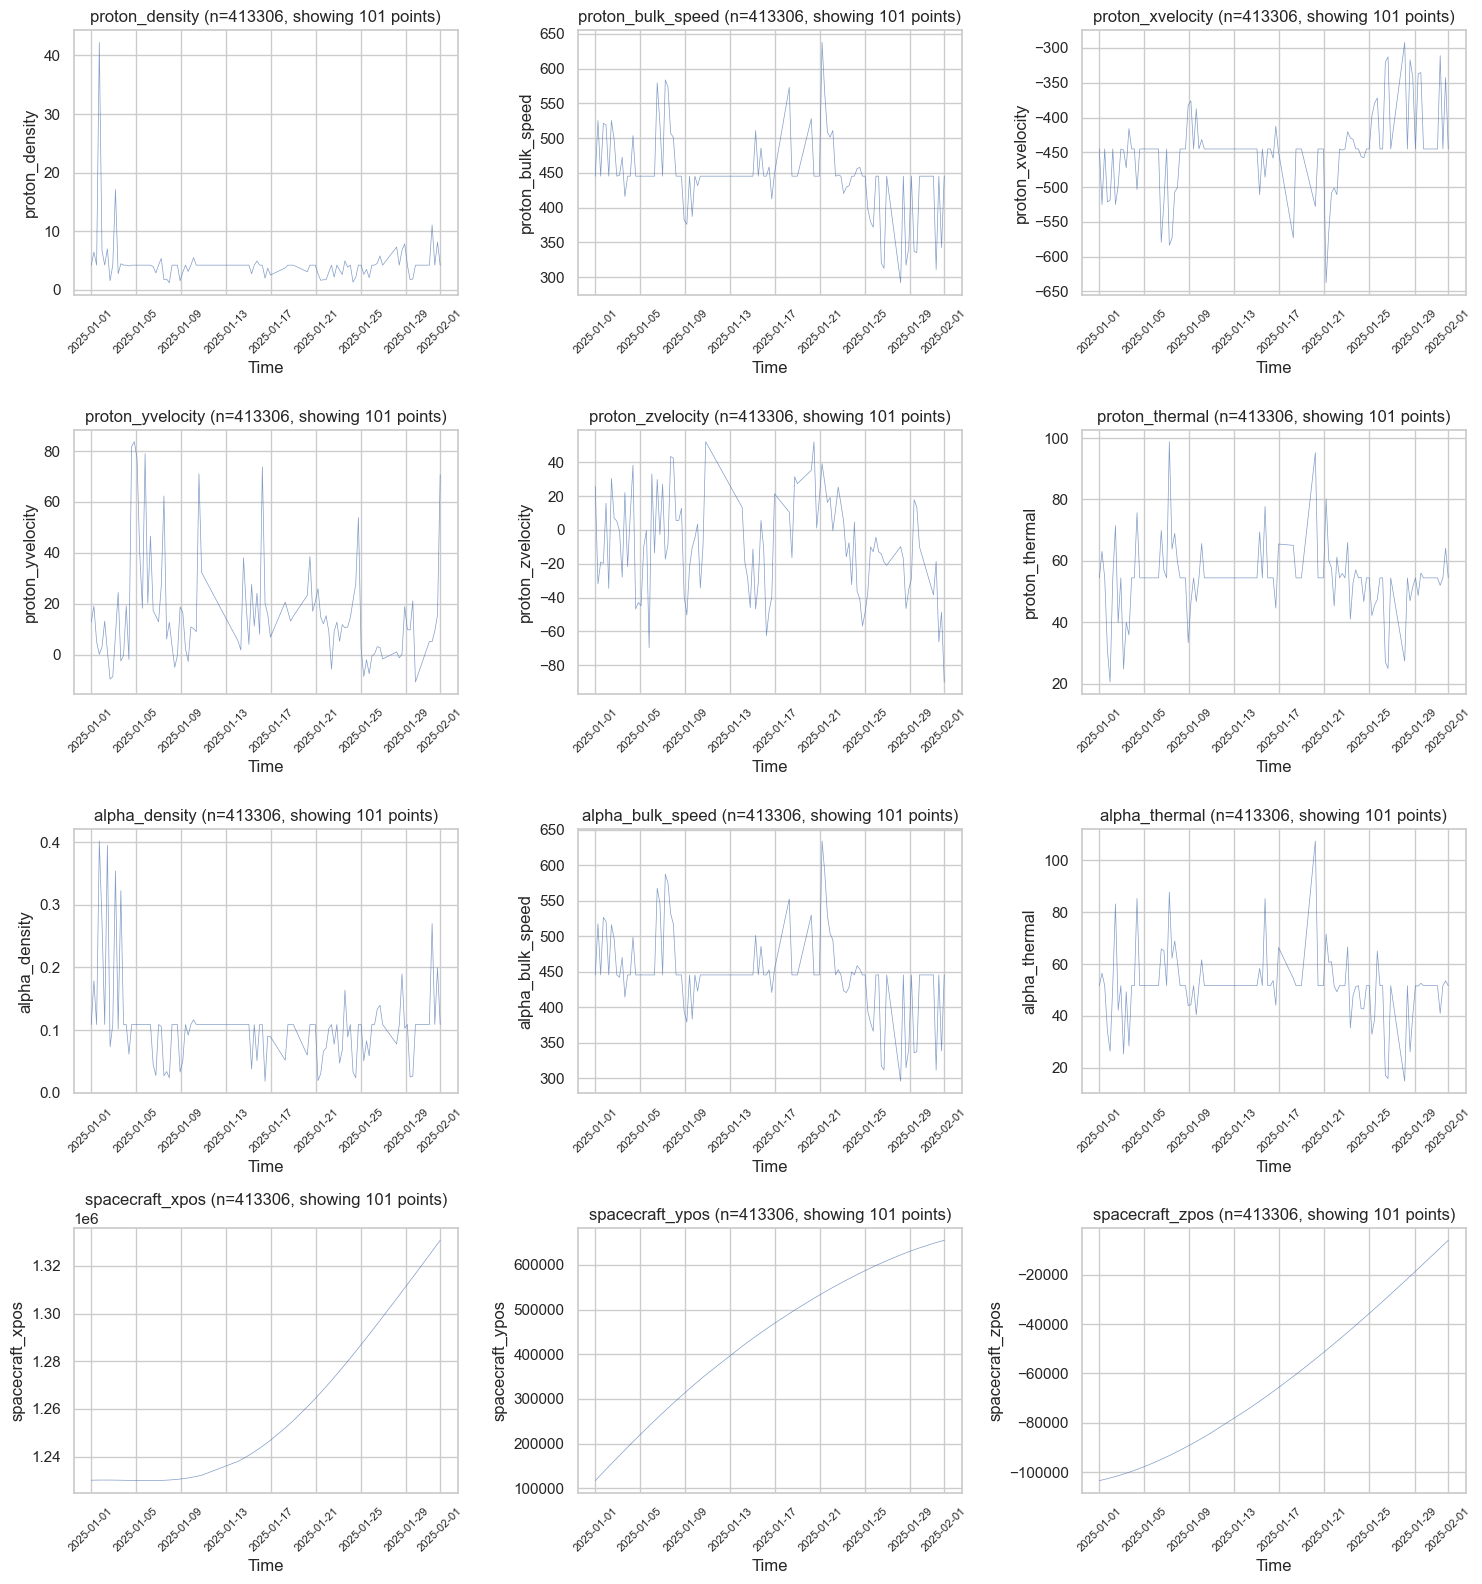

Cleaned data saved to cdf_data\cleaned_data_25_01.csv

Processing folder: data_monthly\data_25_02
Found 23 CDF files.
Total rows: 388479
Total rows: 388479


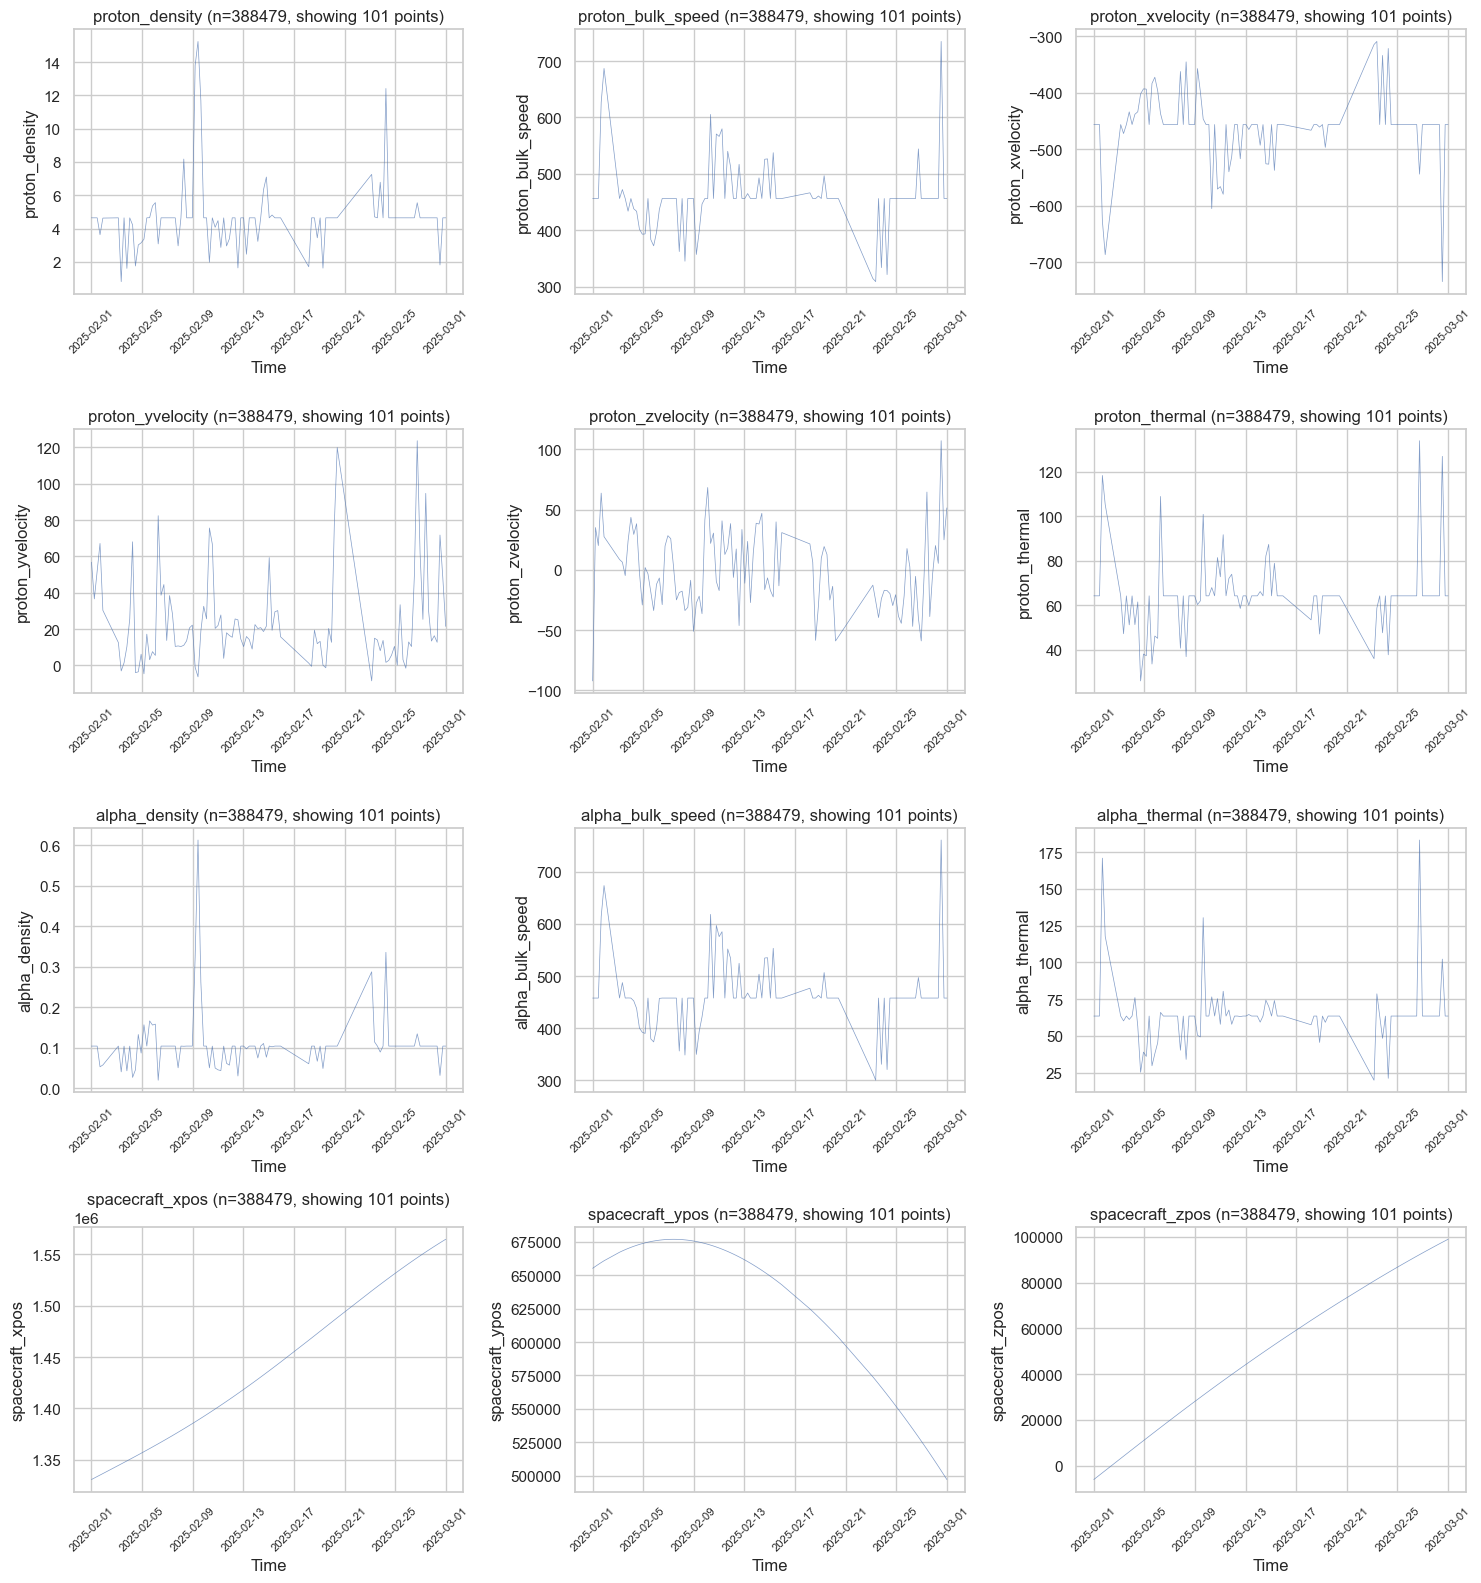

Cleaned data saved to cdf_data\cleaned_data_25_02.csv

Processing folder: data_monthly\data_25_03
Found 29 CDF files.
Total rows: 491291
Total rows: 491291


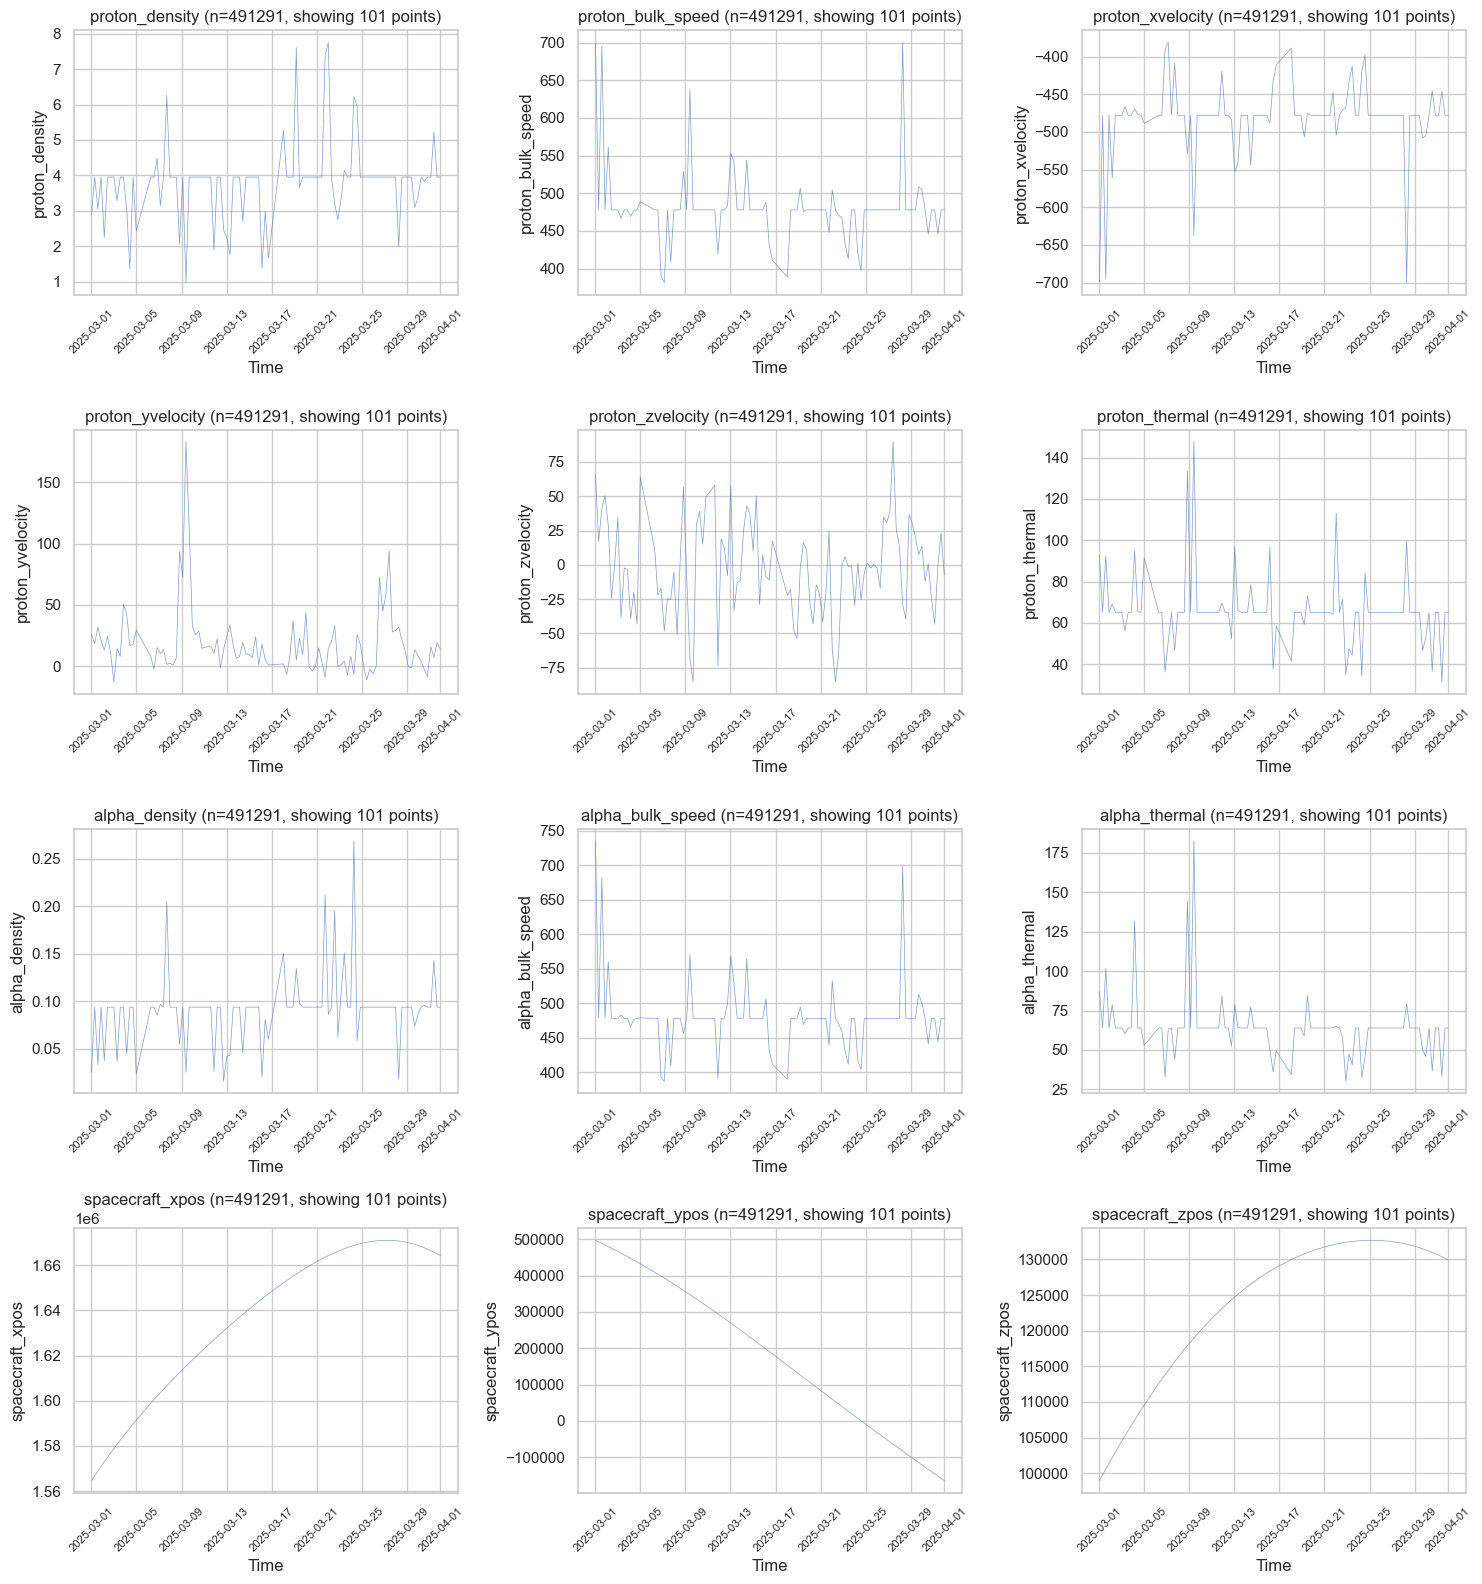

Cleaned data saved to cdf_data\cleaned_data_25_03.csv

Processing folder: data_monthly\data_25_04
Found 28 CDF files.
Total rows: 480199
Total rows: 480199


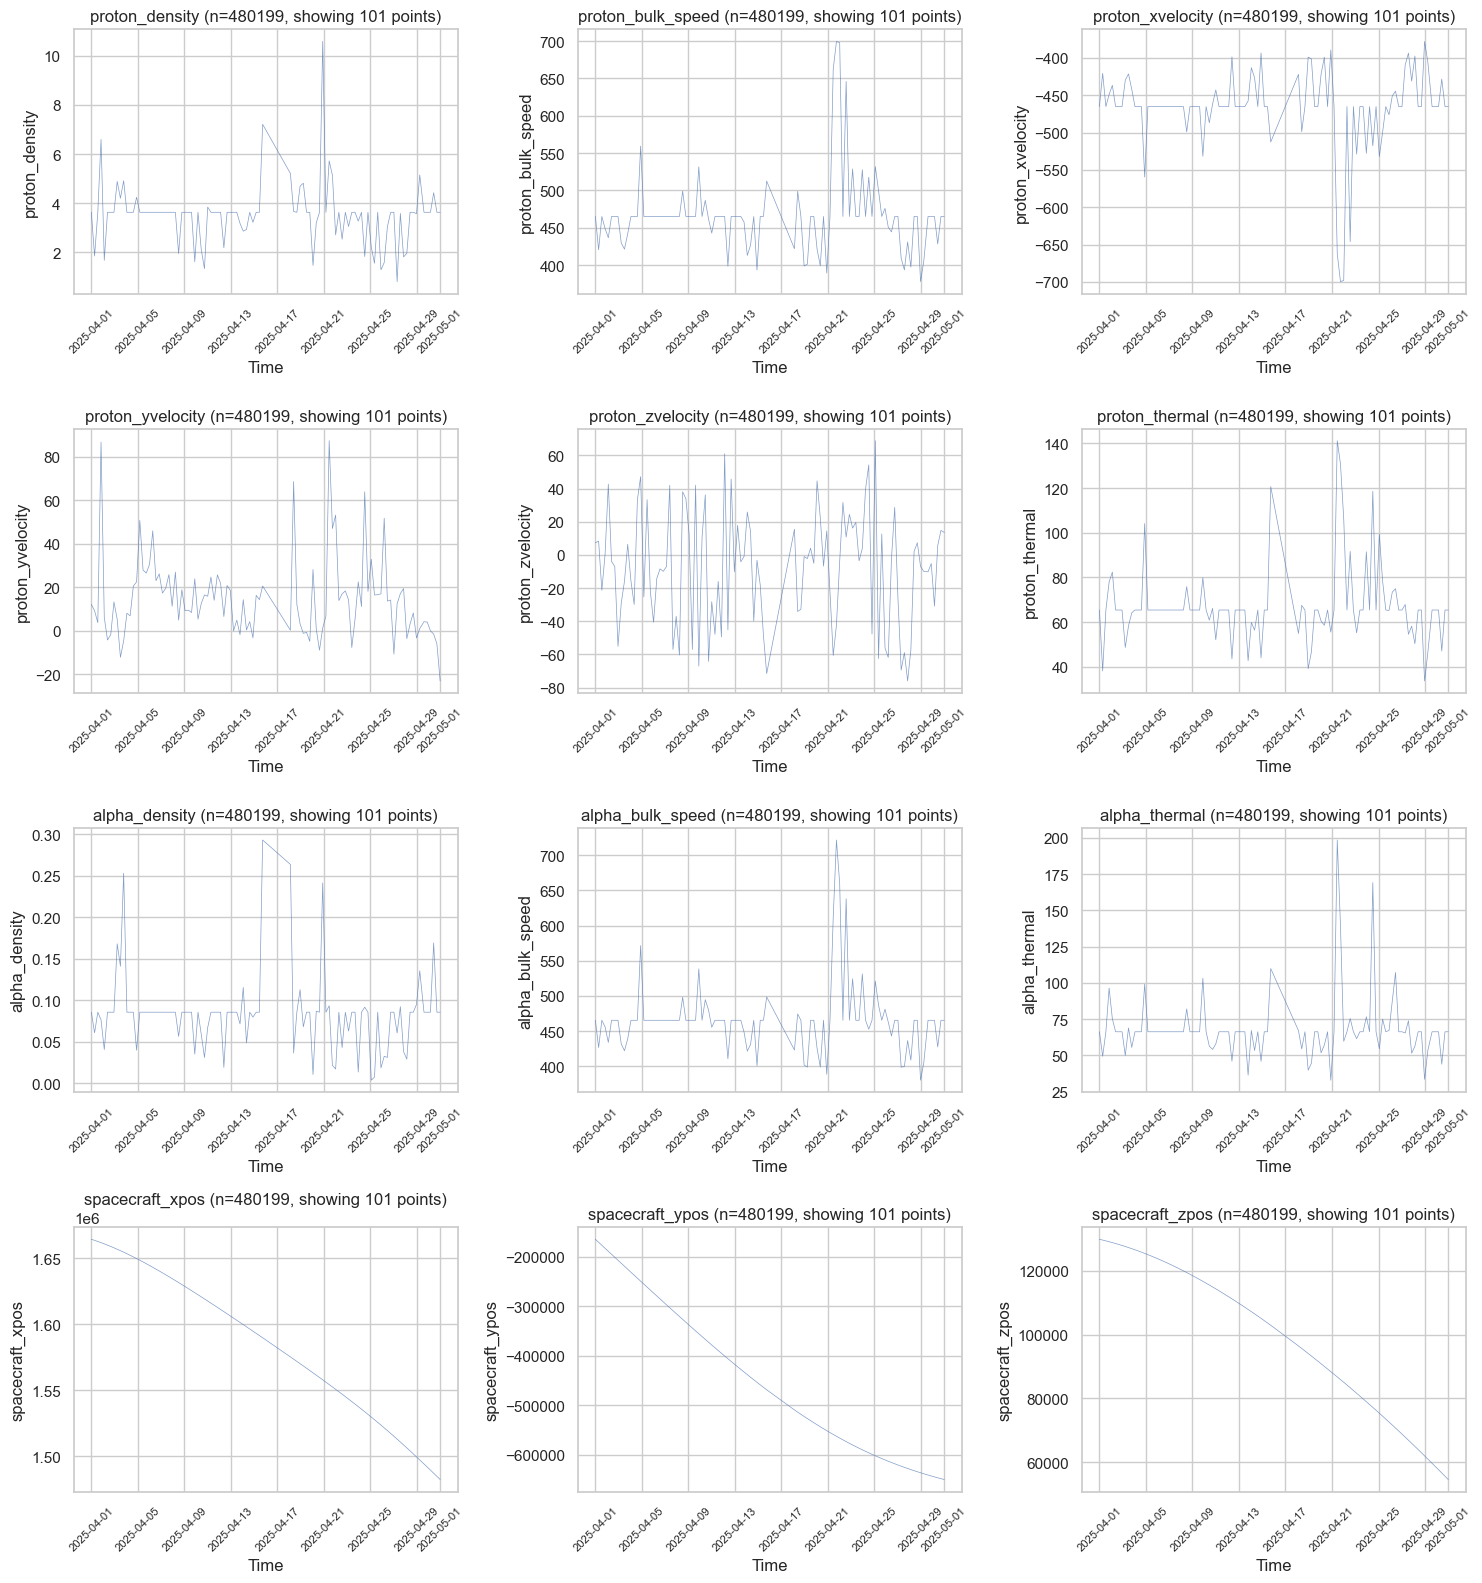

Cleaned data saved to cdf_data\cleaned_data_25_04.csv

Processing folder: data_monthly\data_25_05
Found 31 CDF files.
Total rows: 477301
Total rows: 477301


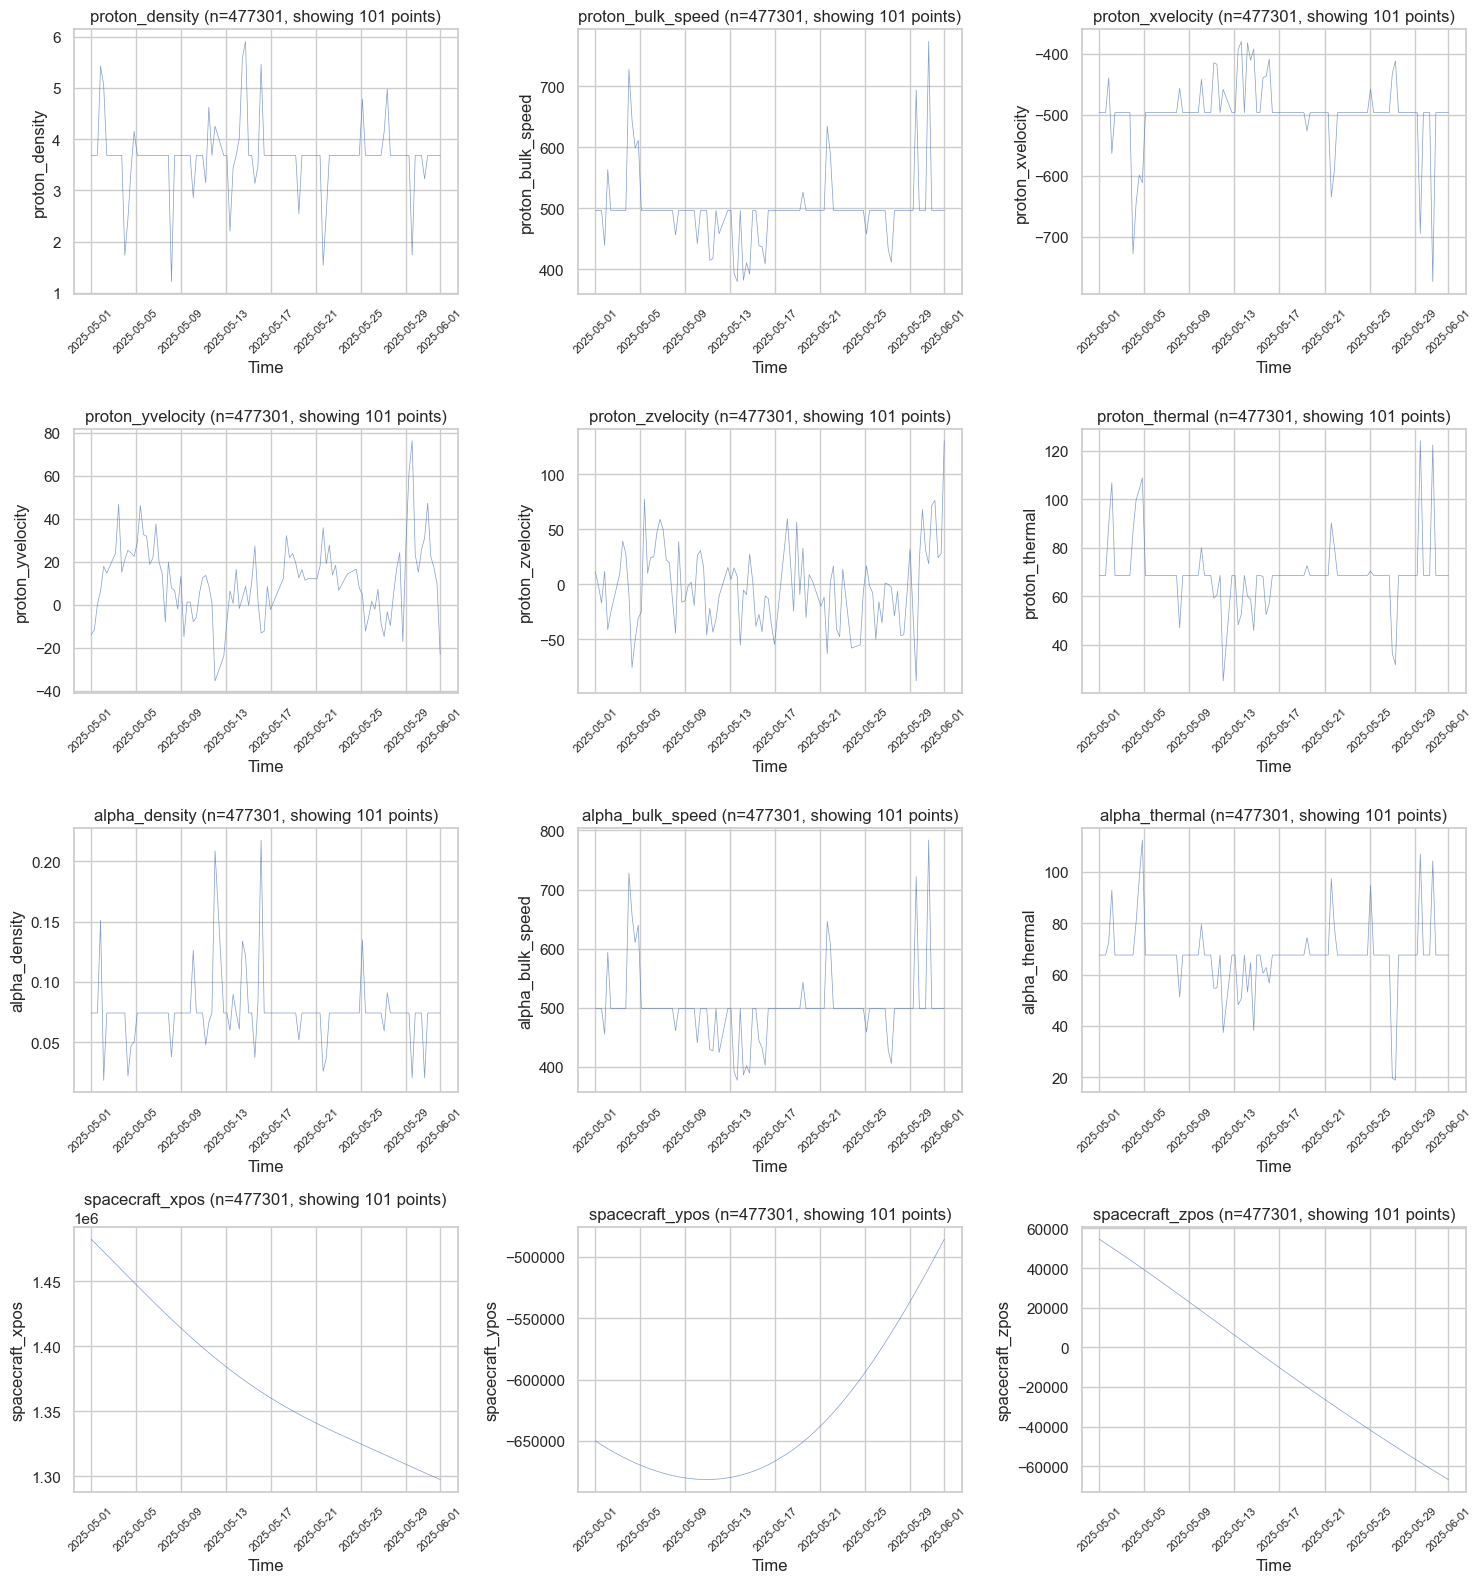

Cleaned data saved to cdf_data\cleaned_data_25_05.csv

Processing folder: data_monthly\data_25_06
Found 27 CDF files.
Total rows: 449031
Total rows: 449031


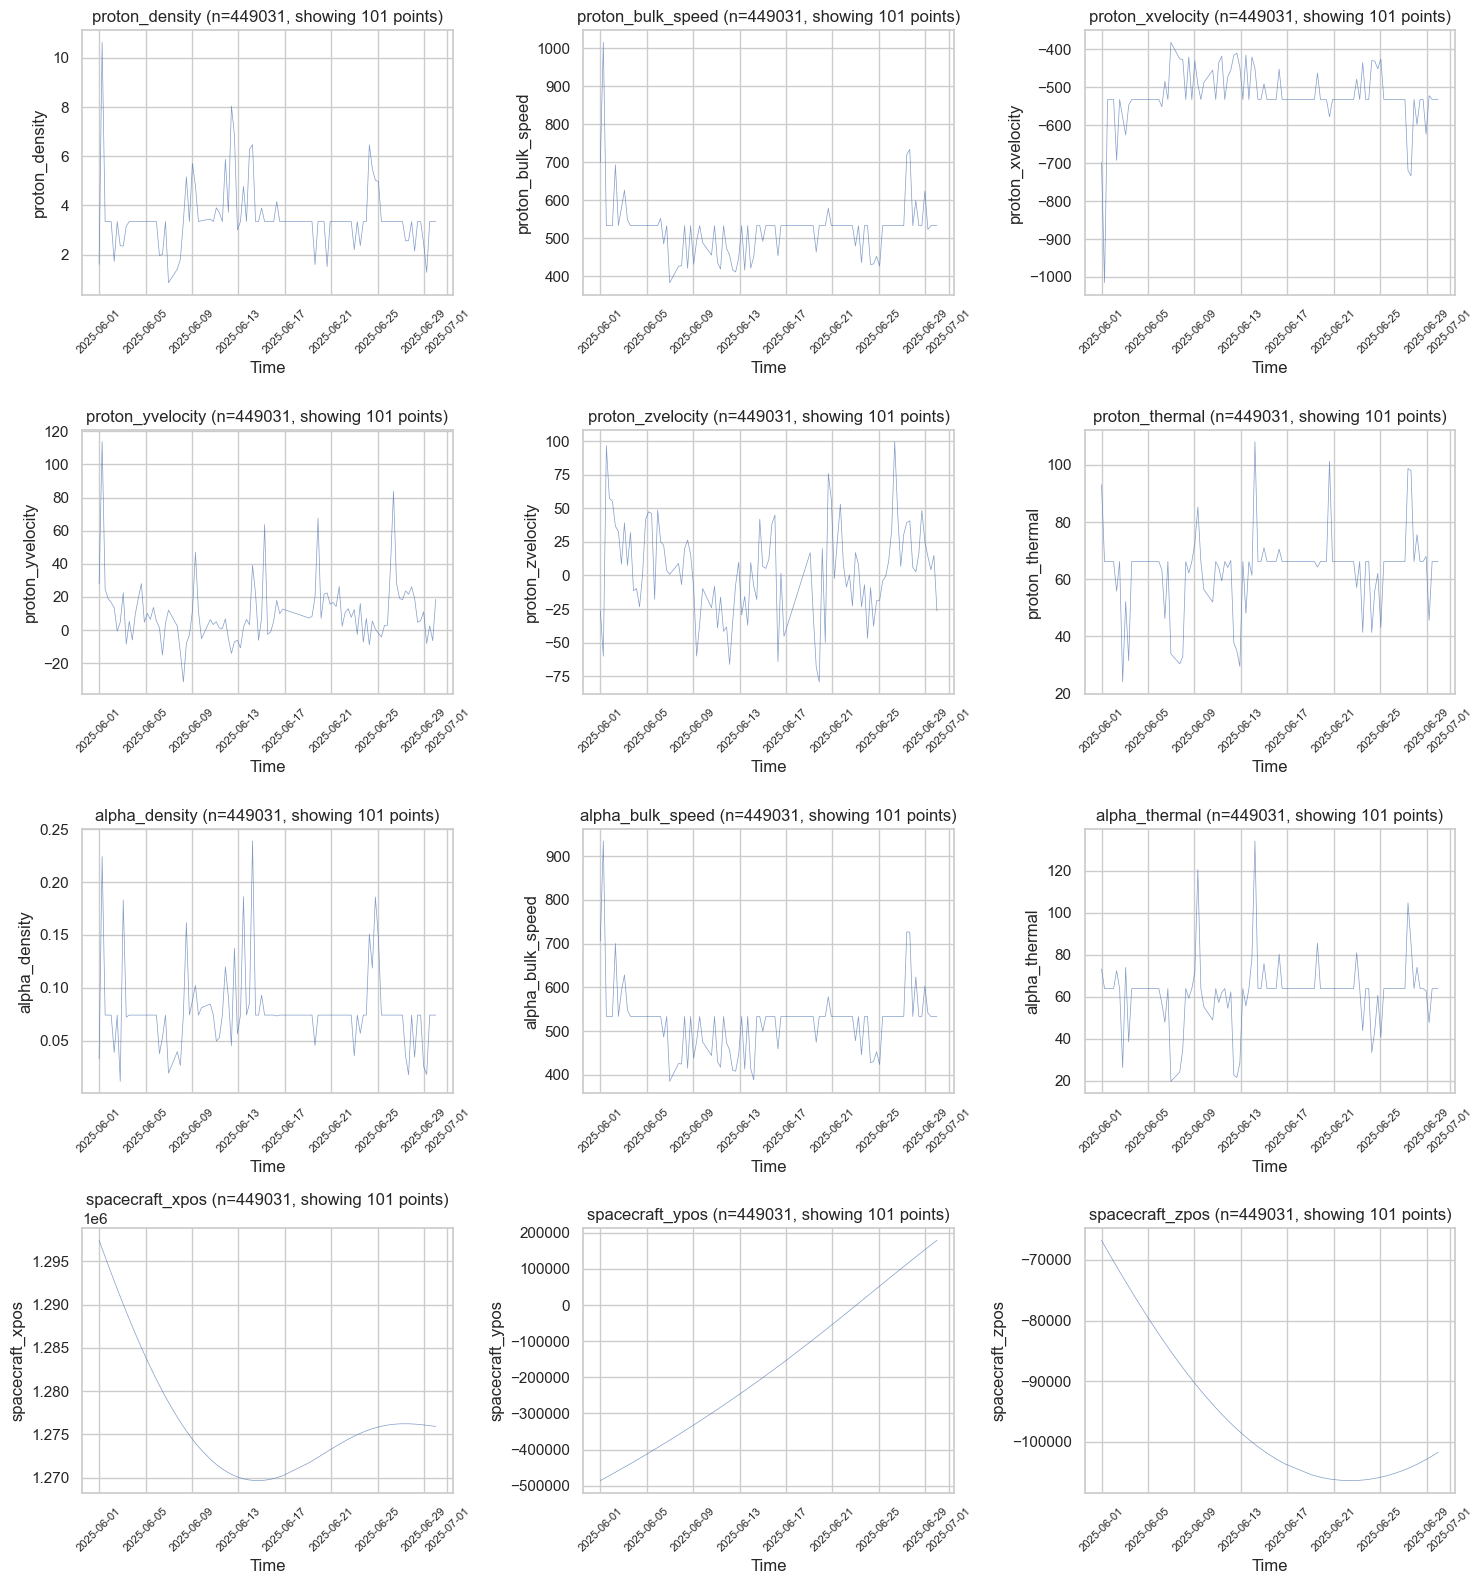

Cleaned data saved to cdf_data\cleaned_data_25_06.csv


In [9]:
# Process each monthly folder and save cleaned CSVs
all_monthly_dfs = {}
for folder in month_folders:
    df_clean = process_cdf_folder(folder)
    if df_clean is not None:
        all_monthly_dfs[os.path.basename(folder)] = df_clean

## Summary

- Each monthly folder is processed separately.
- Cleaned and visualized data for each month is saved as a CSV in the `cdf_data` directory.
- Data cleaning, duplicate removal, and basic visualization are performed for each month.